In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
from scipy.stats import gamma
import pystan 
import pandas as pd
import seaborn as sns
import math
import statistics as st
from matplotlib.backends.backend_pdf import PdfPages
import pickle
import warnings
import ipywidgets 
from tqdm.notebook import tqdm

In [2]:
sm_retention = pickle.load(open('stan_model_Retention_time.pkl', 'rb'))
fit_nuts_Solid_retention = pickle.load(open('fit_nuts_Solid_Retention_time.pkl', 'rb'))
fit_nuts_Liquid_retention = pickle.load(open('fit_nuts_Liquid_Retention_time.pkl', 'rb'))
samples_Liquid_retention = fit_nuts_Liquid_retention.extract(permuted=True)
samples_Solid_retention = fit_nuts_Solid_retention.extract(permuted=True)

In [3]:
sm1 = pickle.load(open('../../Cell Invasion/new stan model.pkl', 'rb'))

fit_27 = pickle.load(open('../../Cell Invasion/fit_27.pkl', 'rb'))
fit_42 = pickle.load(open('../../Cell Invasion/fit_42.pkl', 'rb'))
fit_48 = pickle.load(open('../../Cell Invasion/fit_48.pkl', 'rb'))

samples_27 = fit_27.extract(permuted=True)
samples_42 = fit_42.extract(permuted=True)
samples_48 = fit_48.extract(permuted=True)

In [4]:
sm_Colonic_filling = pickle.load(open('stan_model_Colonic_filling.pkl', 'rb'))
fit_nuts_Colonic_filling = pickle.load(open('fit_nuts_Colonic_filling.pkl', 'rb'))
samples_Colonic_filling = fit_nuts_Colonic_filling.extract(permuted=True)

In [5]:
def rk4 ( y, t, h, f ):
    k1 = h * f( y, t )
    k2 = h * f( y + k1/2, t + h/2 )
    k3 = h * f( y + k2/2, t + h/2 )
    k4 = h * f( y + k3, t + h )
    return  y + ( k1 + 2*k2 + 2*k3 + k4 )/6, t + h

Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Progress:   0%|          | 0/301 [00:00<?, ?it/s]

/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Progress:   0%|          | 0/301 [00:00<?, ?it/s]

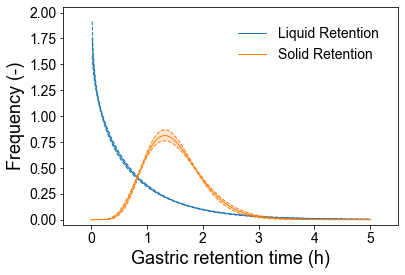

In [6]:
plt.rcParams["font.family"] = "Arial"
Palette=sns.color_palette(n_colors = 3)
plt.xticks(size=14)
plt.yticks(size=14)
x =  np.zeros((5*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, 5, 5*60+1)
for i in tqdm(range(len(samples_Liquid_retention["lp__"])),desc='Progress', leave=False):
    alpha = samples_Liquid_retention["alpha"][i]
    beta = samples_Liquid_retention["beta"][i]
    sigma = samples_Liquid_retention["sigma"][i]
    Liquid_retention_time = 60*gamma.pdf(60*x, alpha, loc=0, scale=1./beta)
    if i == 0:
        Liquid_retention_time_list = Liquid_retention_time
    else:
        Liquid_retention_time_list = np.concatenate([Liquid_retention_time_list, Liquid_retention_time], axis = -1) 

Liquid_retention_time_quantile = np.zeros((5*60+1,7), dtype=float)

for j in tqdm(range(5*60+1),desc='Progress', leave=False):
    Liquid_retention_time_quantile[j,:] = np.quantile(Liquid_retention_time_list[j,:],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    
plt.fill_between(x[:,0], Liquid_retention_time_quantile[:,1], Liquid_retention_time_quantile[:,5], facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], Liquid_retention_time_quantile[:,1], lw=1, color=Palette[0], linestyle='--')
plt.plot(x[:,0], Liquid_retention_time_quantile[:,5], lw=1, color=Palette[0], linestyle='--')
plt.plot(x[:,0], Liquid_retention_time_quantile[:,3], lw=1, color=Palette[0], label="Liquid Retention")


x =  np.zeros((5*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, 5, 5*60+1)
for i in tqdm(range(len(samples_Solid_retention["lp__"])),desc='Progress', leave=False):
    alpha = samples_Solid_retention["alpha"][i]
    beta = samples_Solid_retention["beta"][i]
    sigma = samples_Solid_retention["sigma"][i]
    Solid_retention_time = 60*gamma.pdf(60*x, alpha, loc=0, scale=1./beta)
    if i == 0:
        Solid_retention_time_list = Solid_retention_time
    else:
        Solid_retention_time_list = np.concatenate([Solid_retention_time_list, Solid_retention_time], axis = -1) 

Solid_retention_time_quantile = np.zeros((5*60+1,7), dtype=float)

for j in tqdm(range(5*60+1),desc='Progress', leave=False):
    Solid_retention_time_quantile[j,:] = np.quantile(Solid_retention_time_list[j,:],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    
plt.fill_between(x[:,0], Solid_retention_time_quantile[:,1], Solid_retention_time_quantile[:,5], facecolor=Palette[1], alpha=0.2)
plt.plot(x[:,0], Solid_retention_time_quantile[:,1], lw=1, color=Palette[1], linestyle='--')
plt.plot(x[:,0], Solid_retention_time_quantile[:,5], lw=1, color=Palette[1], linestyle='--')
plt.plot(x[:,0], Solid_retention_time_quantile[:,3], lw=1, color=Palette[1], label="Solid Retention")


plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=18,fontname="Arial")
plt.legend(loc='upper right', borderaxespad=1, fontsize=14, frameon = False)
plt.xlim(-0.5, 5.5)
plt.ylim(-0.05, 2.05)
plt.show()

In [7]:
Tmax = 15
x =  np.zeros((Tmax*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60+1)

Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

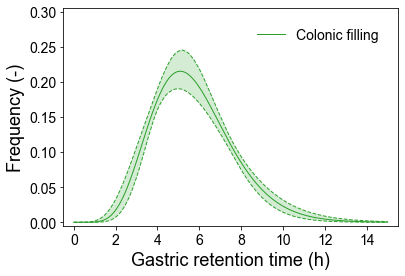

In [8]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
for i in tqdm(range(len(samples_Colonic_filling["lp__"])),desc='Progress', leave=False):
    alpha = samples_Colonic_filling["alpha"][i]
    beta = samples_Colonic_filling["beta"][i]
    Colonic_filling_time = 60*gamma.pdf(60*x, alpha, loc=0, scale=1./beta)
    if i == 0:
        Colonic_filling_time_list = Colonic_filling_time
    else:
        Colonic_filling_time_list = np.concatenate([Colonic_filling_time_list, Colonic_filling_time], axis = -1) 

Colonic_filling_time_quantile = np.zeros((len(x),7), dtype=float)

for j in tqdm(range(len(x)),desc='Progress', leave=False):
    Colonic_filling_time_quantile[j,:] = np.quantile(Colonic_filling_time_list[j,:],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])

plt.fill_between(x[:,0], Colonic_filling_time_quantile[:,1], Colonic_filling_time_quantile[:,5], facecolor=Palette[2], alpha=0.2)
plt.plot(x[:,0], Colonic_filling_time_quantile[:,1], lw=1, color=Palette[2], linestyle='--')
plt.plot(x[:,0], Colonic_filling_time_quantile[:,5], lw=1, color=Palette[2], linestyle='--')
plt.plot(x[:,0], Colonic_filling_time_quantile[:,3], lw=1, color=Palette[2], label="Colonic filling")

plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=18,fontname="Arial")
plt.legend(loc='upper right', borderaxespad=1, fontsize=14, frameon = False)
plt.xlim(-0.5, 15.5)
plt.ylim(-0.005, 0.305)
plt.show()

In [9]:
# Loading Baysian model of gastric reduction
sm_GR_between_strain = pickle.load(open('between-strain model.pkl', 'rb'))
fit_nuts_between_strain = pickle.load(open('fit_nuts_between_strain.pkl', 'rb'))
samples_between_strain = fit_nuts_between_strain.extract(permuted=True)

In [10]:
# Import pH change with individual person variability from .pickle
sm_pH_change = pickle.load(open('Stan model for pH change.pkl', 'rb'))
fit_nuts_pH_change_younger = pickle.load(open('fit_nuts_pH_change_younger.pkl', 'rb'))
fit_nuts_pH_change_elder = pickle.load(open('fit_nuts_pH_change_elder.pkl', 'rb'))
samples_pH_change_younger = fit_nuts_pH_change_younger.extract(permuted=True)
samples_pH_change_elder = fit_nuts_pH_change_elder.extract(permuted=True)

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

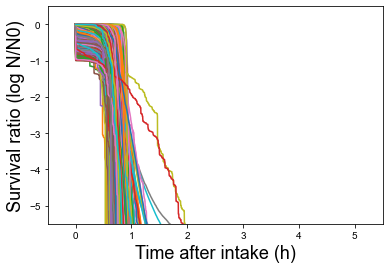

In [11]:
#Repetition of simulation
rep_eat = 1000

# Color Difinition
Palette=sns.color_palette(n_colors = rep_eat)

#Max Time (h) 
Tmax = 15

#Difinition of time-array (h) 
x =  np.zeros((Tmax*60*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60*60+1)

##### Definition of Gastric passage log counts
logSg0_list = []
logSg0 = np.zeros((len(x), 1), dtype=float)
t_star = []

rcn_between_strain_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_pH_list = np.zeros((rep_eat, 1), dtype=int)
pH_Lowest_list = np.zeros((rep_eat, 1), dtype=int)
pH_A_list = np.zeros((rep_eat, 1), dtype=int)
pH_k_list = np.zeros((rep_eat, 1), dtype=int)
pH_sigma_list = np.zeros((rep_eat, 1), dtype=int)
reduction_a_list = np.zeros((rep_eat, 1), dtype=int)
reduction_b_list = np.zeros((rep_eat, 1), dtype=int)
reduction_e_list = np.zeros((rep_eat, 1), dtype=int)
reduction_f_list = np.zeros((rep_eat, 1), dtype=int)


##### Simulation of Gastric passage log counts
warnings.simplefilter('ignore', RuntimeWarning)
for i in tqdm(range(rep_eat), desc = 'Progress', leave = False):
    
    rcn_pH = random.choice(range(len(samples_pH_change_younger["lp__"])))
    rcn_pH_list[i, 0] = rcn_pH
    Lowest = samples_pH_change_younger["Lowest"][rcn_pH]
    A = samples_pH_change_younger["A"][rcn_pH]
    k = samples_pH_change_younger["k"][rcn_pH]
    sigma_pH = samples_pH_change_younger["sigma"][rcn_pH]
    
    pH_Lowest_list[i, 0] = samples_pH_change_younger["Lowest"][rcn_pH]
    pH_A_list[i, 0] = samples_pH_change_younger["A"][rcn_pH]
    pH_k_list[i, 0] = samples_pH_change_younger["k"][rcn_pH]
    pH_sigma_list[i, 0] = samples_pH_change_younger["sigma"][rcn_pH]
    
    

    rcn_between_strain = random.choice(range(len(samples_between_strain["lp__"])))
    rcn_between_strain_list[i, 0] = rcn_between_strain
    abef0 = samples_between_strain["abef0"][rcn_between_strain]
    cov = samples_between_strain["cov"][rcn_between_strain]
    abef = np.random.multivariate_normal(abef0, cov, size = 1)[0]
    a = abef[0]
    b = abef[1]
    e = abef[2]
    f = abef[3]
    
    reduction_a_list[i,0] = a
    reduction_b_list[i,0] = b
    reduction_e_list[i,0] = e
    reduction_f_list[i,0] = f
    
    
    
    # Predict log reduction from between strain model
    for t in range(len(x)):
        if t==0:
            logSg0[t] = 0
            pH_before = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
        else :
            pH_next = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
            pH = (pH_before + pH_next)/2
            pH_before = pH_next
            logd = (a*pH+b)
            logp = e*pH+f
            logdp = [logd, logp]
            d = np.exp(logdp[0])/60
            p = np.exp(logdp[1])
            t_star =  d*(-(logSg0[t-1]))**(1/p)
            logSg0[t] = -((t_star+(x[t]-x[t-1]))/d)**p
    plt.plot(x, logSg0, color=Palette[i])
    
    if i == 0:
        logSg0_list = logSg0
    else:
        logSg0_list = np.concatenate([logSg0_list, logSg0], axis = -1) 
        
plt.rcParams["font.family"] = "Arial"

plt.ylabel("Survival ratio (log N/N0)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)",size=18,fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()


In [12]:
x =  np.zeros((Tmax*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60+1)
logSg0_min = np.zeros((len(x), len(logSg0_list[0,:])), dtype=float)

for i in range(len(x)):
    logSg0_min[i,:] = logSg0_list[i*60,:]

logSg0_list=logSg0_min
logSg0_min=0

In [13]:
logSg0_quantile = np.zeros((len(logSg0_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(logSg0_list[:,0])),desc='Progress', leave=False):
    logSg0_quantile[n,:] =  np.quantile(logSg0_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

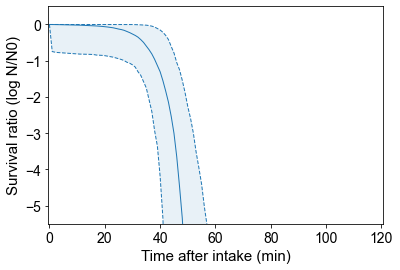

In [14]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0]*60, logSg0_quantile[:,0], logSg0_quantile[:,2], facecolor=Palette[0], alpha=0.1)
plt.plot(x[:,0]*60, logSg0_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0]*60, logSg0_quantile[:,0], lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0]*60, logSg0_quantile[:,1], lw=1, color=Palette[0], label="Survival ratio")

plt.ylabel("Survival ratio (log N/N0)", size=15, fontname="Arial")
plt.xlabel("Time after intake (min)",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-0.5, 120.5)
plt.ylim(-5.5, 0.5)
plt.show()

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

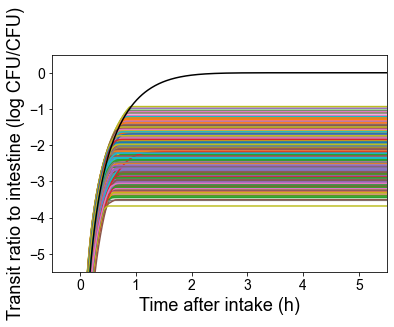

In [15]:
Ni_list = []

plt.rcParams["font.family"] = "Arial"

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Solid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Solid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Solid_retention["beta"][rcn_gastric_retention]
    
    
    
    for i in range(len(x)):
        Sg = 10**logSg_using[i]
        
        dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Ni_t = Ni_t + dNi
        Ni[i, 0] = Ni_t
        
        dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Total_t = Total_t + dTotal
        Total[i, 0] = Total_t    

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Transit ratio to intestine (log CFU/CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [16]:
with open('Ni_Solid_younger.pkl', 'wb') as f:

    pickle.dump(Ni_list, f)

In [17]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

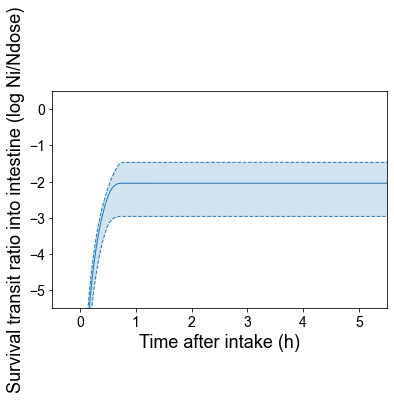

In [18]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


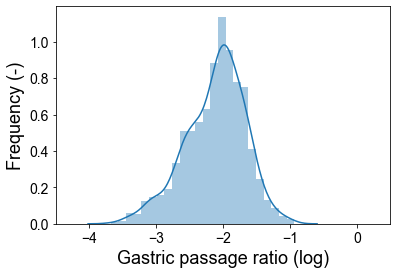

In [19]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [20]:
V = 319
Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.arange(-2, 6+1/10, 1/10, dtype="float")

S = 32*10**4

P_invasion_27_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_27_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_27_mean = np.zeros((len(logdose),1), dtype=float)
ratio_27_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)


P_invasion_42_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_42_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_42_mean = np.zeros((len(logdose),1), dtype=float)

P_invasion_48_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_48_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_48_mean = np.zeros((len(logdose),1), dtype=float)


In [21]:
for n in tqdm(range(len(logdose)) ,desc='Progress', leave=False):
    warnings.simplefilter('ignore', RuntimeWarning)
    for k in tqdm(range(len(Ni_min[0, :])),desc='Progress', leave=False):

        rcn = random.randrange(len(samples_27["LogNmax"]))
        LogNmax_27 = samples_27["LogNmax"][rcn]
        Logmu_27 = samples_27["Logmu"][rcn]
        Nmax_27 = 10**LogNmax_27
        mu_27 = 10**Logmu_27

        LogNmax_42 = samples_42["LogNmax"][rcn]
        Logmu_42 = samples_42["Logmu"][rcn]
        Nmax_42 = 10**LogNmax_42
        mu_42 = 10**Logmu_42

        LogNmax_48 = samples_48["LogNmax"][rcn]
        Logmu_48 = samples_48["Logmu"][rcn]
        Nmax_48 = 10**LogNmax_48
        mu_48 = 10**Logmu_48

        for i in range(len(Ni_min[:, 0])):
        
            Ni = Ni_min[i, k]*10**logdose[n]
            
            T = i/60
            h = 1/60
    
            def ODE_27 (y, t):
                return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

            def ODE_42 (y, t):
                return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

            def ODE_48 (y, t):
                return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
            if i==0:
                Nc_min_27[i, k] = 0
                Nc_min_42[i, k] = 0
                Nc_min_48[i, k] = 0
                
            else:
                
                Nc_min_mean_27[i, k] = rk4 ( Nc_min_mean_27[i-1, k], T-h, h, ODE_27)[0]
                Nc_min_27[i, k] = Nc_min_mean_27[i, k]
        
                Nc_min_mean_42[i, k] = rk4 ( Nc_min_mean_42[i-1, k], T-h, h, ODE_42)[0]
                Nc_min_42[i, k] = Nc_min_mean_42[i, k]
        
                Nc_min_mean_48[i, k] = rk4 ( Nc_min_mean_48[i-1, k], T-h, h, ODE_48)[0]
                Nc_min_48[i, k] = Nc_min_mean_48[i, k]

        
        rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
        t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn],
                                        1/samples_Colonic_filling["beta"][rcn])))
        t = np.min((t,len(Ni_min[:, 0])-1))

        ratio_27 = Nc_min_27[t,k]/10**logdose[n] 
        P_invasion_27 =  1- (1-ratio_27)**(10**logdose[n])
        P_invasion_27_mcmc[n,k] = P_invasion_27
        
        ratio_42 = Nc_min_42[t,k]/10**logdose[n] 
        P_invasion_42 =  1- (1-ratio_42)**(10**logdose[n])
        P_invasion_42_mcmc[n,k] = P_invasion_42
        
        ratio_48 = Nc_min_48[t,k]/10**logdose[n]    
        P_invasion_48 =  1- (1-ratio_48)**(10**logdose[n])
        P_invasion_48_mcmc[n,k] = P_invasion_48
        
        
    P_invasion_27_quantile[n,:] =  np.quantile(P_invasion_27_mcmc[n,:][np.invert(np.isnan(P_invasion_27_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_27_mean[n,:] =  np.mean(P_invasion_27_mcmc[n,:][np.invert(np.isinf(P_invasion_27_mcmc[n,:])|np.isnan(P_invasion_27_mcmc[n,:]))])
    
    P_invasion_42_quantile[n,:] =  np.quantile(P_invasion_42_mcmc[n,:][np.invert(np.isnan(P_invasion_42_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_42_mean[n,:] =  np.mean(P_invasion_42_mcmc[n,:][np.invert(np.isinf(P_invasion_42_mcmc[n,:])|np.isnan(P_invasion_42_mcmc[n,:]))])
    
    P_invasion_48_quantile[n,:] =  np.quantile(P_invasion_48_mcmc[n,:][np.invert(np.isnan(P_invasion_48_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_48_mean[n,:] =  np.mean(P_invasion_48_mcmc[n,:][np.invert(np.isinf(P_invasion_48_mcmc[n,:])|np.isnan(P_invasion_48_mcmc[n,:]))])

Progress:   0%|          | 0/81 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

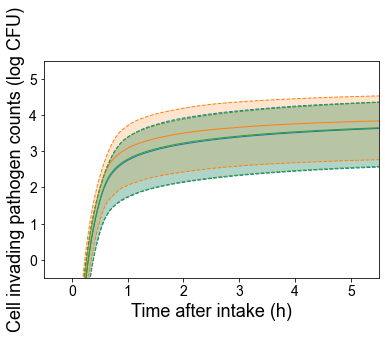

6.000000000000007


In [22]:
Nc_min_27_quantile = np.zeros((len(Ni_list[:,0]), 7), dtype=float)
Nc_min_42_quantile = np.zeros((len(Ni_list[:,0]), 7), dtype=float)
Nc_min_48_quantile = np.zeros((len(Ni_list[:,0]), 7), dtype=float)

for i in range(len(Nc_min_48[:, 0])):
    Nc_min_27_quantile[i, :] =  np.quantile(Nc_min_27[i, :],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    Nc_min_42_quantile[i, :] =  np.quantile(Nc_min_42[i, :],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    Nc_min_48_quantile[i, :] =  np.quantile(Nc_min_48[i, :],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
plt.figure()

plt.fill_between(x[:,0], np.log10(Nc_min_27_quantile[:,1]), np.log10(Nc_min_27_quantile[:,5]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Nc_min_27_quantile[:,1]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Nc_min_27_quantile[:,5]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Nc_min_27_quantile[:,3]), lw=1, color=Palette[0])

plt.fill_between(x[:,0], np.log10(Nc_min_42_quantile[:,1]), np.log10(Nc_min_42_quantile[:,5]), facecolor=Palette[1], alpha=0.2)
plt.plot(x[:,0], np.log10(Nc_min_42_quantile[:,1]), lw=1, color=Palette[1],linestyle='--')
plt.plot(x[:,0], np.log10(Nc_min_42_quantile[:,5]), lw=1, color=Palette[1],linestyle='--')
plt.plot(x[:,0], np.log10(Nc_min_42_quantile[:,3]), lw=1, color=Palette[1])

plt.fill_between(x[:,0], np.log10(Nc_min_48_quantile[:,1]), np.log10(Nc_min_48_quantile[:,5]), facecolor=Palette[2], alpha=0.2)
plt.plot(x[:,0], np.log10(Nc_min_48_quantile[:,1]), lw=1, color=Palette[2],linestyle='--')
plt.plot(x[:,0], np.log10(Nc_min_48_quantile[:,5]), lw=1, color=Palette[2],linestyle='--')
plt.plot(x[:,0], np.log10(Nc_min_48_quantile[:,3]), lw=1, color=Palette[2])

plt.rcParams["font.family"] = "Arial"

plt.ylabel("Cell invading pathogen counts (log CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")

plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-0.5, 5.5)
plt.ylim(-0.5, 5.5)
plt.show()
print(logdose[n])

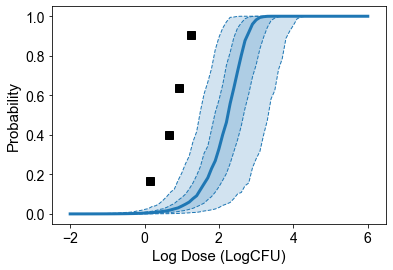

In [23]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_27_quantile[:,1], P_invasion_27_quantile[:,5], 
                 facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,1], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,5], lw=1, color=Palette[0],linestyle='--')


plt.fill_between(logdose, P_invasion_27_quantile[:,2], P_invasion_27_quantile[:,4], 
                 facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,4], lw=1, color=Palette[0],linestyle='--')


plt.plot(logdose, P_invasion_27_quantile[:,3], lw=3, color=Palette[0], label="RIMD 0366027")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [24]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_27_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

1.4838299180938488

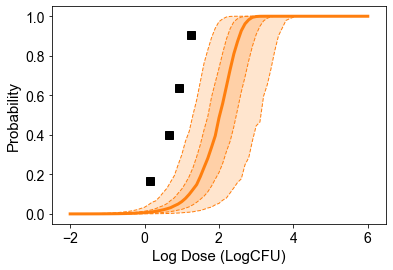

In [25]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_42_quantile[:,1], P_invasion_42_quantile[:,5], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,1], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,5], lw=1, color=Palette[1],linestyle='--')


plt.fill_between(logdose, P_invasion_42_quantile[:,2], P_invasion_42_quantile[:,4], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,2], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,4], lw=1, color=Palette[1],linestyle='--')


plt.plot(logdose, P_invasion_42_quantile[:,3], lw=3, color=Palette[1], label="RIMD 0366042")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [26]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_42_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

1.2839491498435742

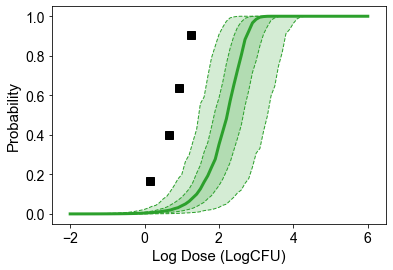

In [27]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_48_quantile[:,1], P_invasion_48_quantile[:,5], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,1], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,5], lw=1, color=Palette[2],linestyle='--')


plt.fill_between(logdose, P_invasion_48_quantile[:,2], P_invasion_48_quantile[:,4], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,2], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,4], lw=1, color=Palette[2],linestyle='--')


plt.plot(logdose, P_invasion_48_quantile[:,3], lw=3, color=Palette[2], label="RIMD 0366048")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [28]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_48_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

1.4838299180938488

In [29]:
P_invasion_mcmc = np.concatenate([P_invasion_27_mcmc, P_invasion_42_mcmc, P_invasion_48_mcmc], 1)
P_invasion_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_mean = np.zeros((len(logdose), 1), dtype=float)
for i in range(len(logdose)):
    P_invasion_quantile[i,:] =  np.quantile(P_invasion_mcmc[i,:][np.invert(np.isnan(P_invasion_mcmc[i,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_mean[i,0] =  np.mean(P_invasion_mcmc[i,:])

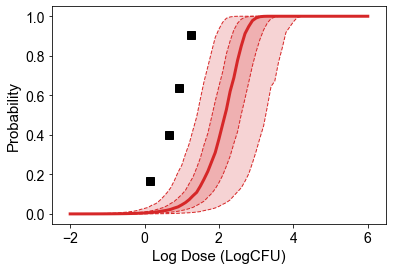

In [30]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_quantile[:,1], P_invasion_quantile[:,5], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,1], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,5], lw=1, color=Palette[3],linestyle='--')


plt.fill_between(logdose, P_invasion_quantile[:,2], P_invasion_quantile[:,4], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,2], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,4], lw=1, color=Palette[3],linestyle='--')


plt.plot(logdose, P_invasion_quantile[:,3], lw=3, color=Palette[3], label="Total of isolations")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [31]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

1.40880824051246

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

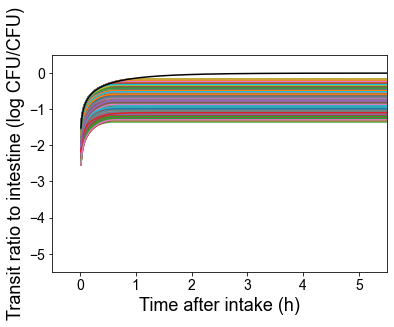

In [32]:
Ni_list = []

plt.rcParams["font.family"] = "Arial"
Palette=sns.color_palette(n_colors = rep_eat)

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Liquid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Liquid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Liquid_retention["beta"][rcn_gastric_retention]
    
    for i in tqdm(range(len(x)),desc='Progress', leave=False):
        if i == 0:
            Ni[i, 0] = 0
        else:
            Sg = 10**logSg_using[i]
        
            dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Ni_t = Ni_t + dNi
            Ni[i, 0] = Ni_t
        
            dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Total_t = Total_t + dTotal
            Total[i, 0] = Total_t    

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Transit ratio to intestine (log CFU/CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [33]:
with open('Ni_Liquid_younger.pkl', 'wb') as f:

    pickle.dump(Ni_list, f)

In [34]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

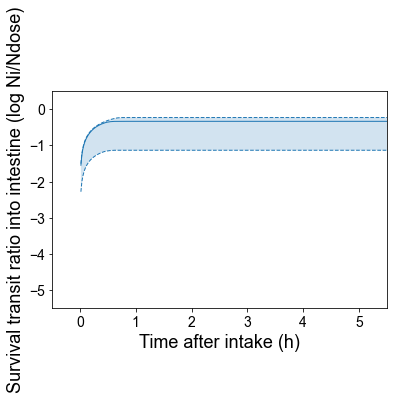

In [35]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


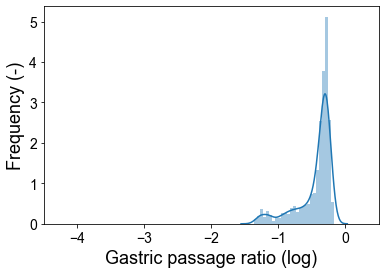

In [36]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [37]:
V = 319
S = 32*10**4

Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.arange(-2, 6+1/10, 1/10, dtype="float")


P_invasion_27_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_27_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_27_mean = np.zeros((len(logdose),1), dtype=float)

P_invasion_42_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_42_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_42_mean = np.zeros((len(logdose),1), dtype=float)

P_invasion_48_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_48_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_48_mean = np.zeros((len(logdose),1), dtype=float)

In [38]:
ratio_42_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
for n in tqdm(range(len(logdose)) ,desc='Progress', leave=False):
    warnings.simplefilter('ignore', RuntimeWarning)
    for k in tqdm(range(len(Ni_min[0, :])),desc='Progress', leave=False):

        rcn = random.randrange(len(samples_27["LogNmax"]))
        LogNmax_27 = samples_27["LogNmax"][rcn]
        Logmu_27 = samples_27["Logmu"][rcn]
        Nmax_27 = 10**LogNmax_27
        mu_27 = 10**Logmu_27

        LogNmax_42 = samples_42["LogNmax"][rcn]
        Logmu_42 = samples_42["Logmu"][rcn]
        Nmax_42 = 10**LogNmax_42
        mu_42 = 10**Logmu_42

        LogNmax_48 = samples_48["LogNmax"][rcn]
        Logmu_48 = samples_48["Logmu"][rcn]
        Nmax_48 = 10**LogNmax_48
        mu_48 = 10**Logmu_48

        for i in range(len(Ni_min[:, 0])):
        
            Ni = Ni_min[i, k]*10**logdose[n]
            
            T = i/60
            h = 1/60
    
            def ODE_27 (y, t):
                return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

            def ODE_42 (y, t):
                return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

            def ODE_48 (y, t):
                return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
            if i==0:
                Nc_min_27[i, k] = 0
                Nc_min_42[i, k] = 0
                Nc_min_48[i, k] = 0
                
            else:
                
                Nc_min_mean_27[i, k] = rk4 ( Nc_min_mean_27[i-1, k], T-h, h, ODE_27)[0]
                Nc_min_27[i, k] = Nc_min_mean_27[i, k]
        
                Nc_min_mean_42[i, k] = rk4 ( Nc_min_mean_42[i-1, k], T-h, h, ODE_42)[0]
                Nc_min_42[i, k] = Nc_min_mean_42[i, k]
        
                Nc_min_mean_48[i, k] = rk4 ( Nc_min_mean_48[i-1, k], T-h, h, ODE_48)[0]
                Nc_min_48[i, k] = Nc_min_mean_48[i, k]

        
        rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
        t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn],
                                        1/samples_Colonic_filling["beta"][rcn])))
        t = np.min((t,len(Ni_min[:, 0])-1))

        ratio_27 = Nc_min_27[t,k]/10**logdose[n]    
        ratio_27_mcmc[n,k] = ratio_27
        P_invasion_27 =  1- (1-ratio_27)**(10**logdose[n])
        P_invasion_27_mcmc[n,k] = P_invasion_27
        
        ratio_42 = Nc_min_42[t,k]/10**logdose[n] 
        ratio_42_mcmc[n,k] = ratio_42
        P_invasion_42 =  1- (1-ratio_42)**(10**logdose[n])
        P_invasion_42_mcmc[n,k] = P_invasion_42
        
        ratio_48 = Nc_min_48[t,k]/10**logdose[n]    
        P_invasion_48 =  1- (1-ratio_48)**(10**logdose[n])
        P_invasion_48_mcmc[n,k] = P_invasion_48
        
        
    P_invasion_27_quantile[n,:] =  np.quantile(P_invasion_27_mcmc[n,:][np.invert(np.isnan(P_invasion_27_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_27_mean[n,:] =  np.mean(P_invasion_27_mcmc[n,:][np.invert(np.isinf(P_invasion_27_mcmc[n,:])|np.isnan(P_invasion_27_mcmc[n,:]))])
    
    P_invasion_42_quantile[n,:] =  np.quantile(P_invasion_42_mcmc[n,:][np.invert(np.isnan(P_invasion_42_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_42_mean[n,:] =  np.mean(P_invasion_42_mcmc[n,:][np.invert(np.isinf(P_invasion_42_mcmc[n,:])|np.isnan(P_invasion_42_mcmc[n,:]))])
    
    P_invasion_48_quantile[n,:] =  np.quantile(P_invasion_48_mcmc[n,:][np.invert(np.isnan(P_invasion_48_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_48_mean[n,:] =  np.mean(P_invasion_48_mcmc[n,:][np.invert(np.isinf(P_invasion_48_mcmc[n,:])|np.isnan(P_invasion_48_mcmc[n,:]))])

Progress:   0%|          | 0/81 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

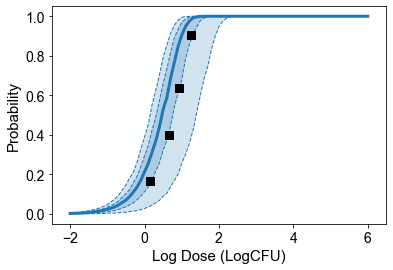

In [39]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_27_quantile[:,1], P_invasion_27_quantile[:,5], facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,1], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,5], lw=1, color=Palette[0],linestyle='--')


plt.fill_between(logdose, P_invasion_27_quantile[:,2], P_invasion_27_quantile[:,4], facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,4], lw=1, color=Palette[0],linestyle='--')


plt.plot(logdose, P_invasion_27_quantile[:,3], lw=3, color=Palette[0], label="RIMD 0366027")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [40]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_27_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.2711967300084395

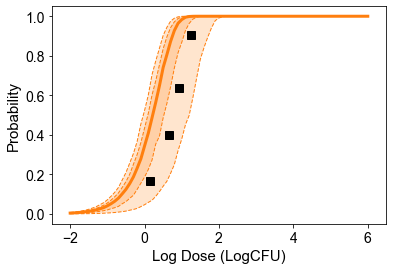

In [41]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_42_quantile[:,1], P_invasion_42_quantile[:,5], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,1], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,5], lw=1, color=Palette[1],linestyle='--')


plt.fill_between(logdose, P_invasion_42_quantile[:,2], P_invasion_42_quantile[:,4], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,2], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,4], lw=1, color=Palette[1],linestyle='--')


plt.plot(logdose, P_invasion_42_quantile[:,3], lw=3, color=Palette[1], label="RIMD 0366042")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [42]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_42_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.5191273074755298

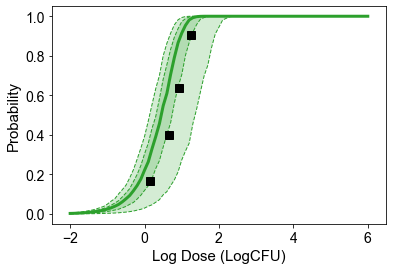

In [43]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_48_quantile[:,1], P_invasion_48_quantile[:,5], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,1], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,5], lw=1, color=Palette[2],linestyle='--')


plt.fill_between(logdose, P_invasion_48_quantile[:,2], P_invasion_48_quantile[:,4], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,2], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,4], lw=1, color=Palette[2],linestyle='--')


plt.plot(logdose, P_invasion_48_quantile[:,3], lw=3, color=Palette[2], label="RIMD 0366048")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [44]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_48_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.2955017829755824

In [45]:
P_invasion_mcmc = np.concatenate([P_invasion_27_mcmc, P_invasion_42_mcmc, P_invasion_48_mcmc], 1)
P_invasion_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_mean = np.zeros((len(logdose), 1), dtype=float)
for i in range(len(logdose)):
    P_invasion_quantile[i,:] =  np.quantile(P_invasion_mcmc[i,:][np.invert(np.isnan(P_invasion_mcmc[i,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_mean[i,0] =  np.mean(P_invasion_mcmc[i,:])

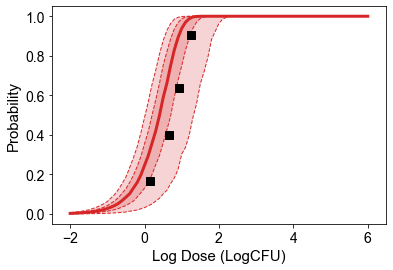

In [46]:
plt.figure()
plt.rcParams["font.family"] = "Arial"
Palette=sns.color_palette(n_colors=4)

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_quantile[:,1], P_invasion_quantile[:,5], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,1], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,5], lw=1, color=Palette[3],linestyle='--')


plt.fill_between(logdose, P_invasion_quantile[:,2], P_invasion_quantile[:,4], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,2], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,4], lw=1, color=Palette[3],linestyle='--')


plt.plot(logdose, P_invasion_quantile[:,3], lw=3, color=Palette[3], label="Total of isolations")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [47]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.3421483069110075

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

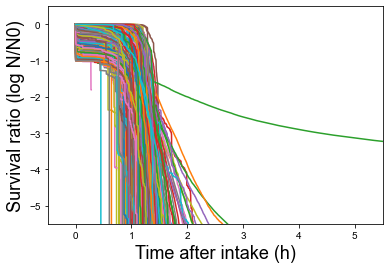

In [48]:

# Color Difinition
Palette=sns.color_palette(n_colors = rep_eat)

#Max Time (h) 
Tmax = 15

#Difinition of time-array (h) 
x =  np.zeros((Tmax*60*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60*60+1)

##### Definition of Gastric passage log counts
logSg0_list = []
logSg0 = np.zeros((len(x), 1), dtype=float)
t_star = []

rcn_between_strain_list = np.zeros((rep_eat, 1), dtype=int)
rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)
rcn_pH_list = np.zeros((rep_eat, 1), dtype=int)
pH_Lowest_list = np.zeros((rep_eat, 1), dtype=int)
pH_A_list = np.zeros((rep_eat, 1), dtype=int)
pH_k_list = np.zeros((rep_eat, 1), dtype=int)
pH_sigma_list = np.zeros((rep_eat, 1), dtype=int)
reduction_a_list = np.zeros((rep_eat, 1), dtype=int)
reduction_b_list = np.zeros((rep_eat, 1), dtype=int)
reduction_e_list = np.zeros((rep_eat, 1), dtype=int)
reduction_f_list = np.zeros((rep_eat, 1), dtype=int)


##### Simulation of Gastric passage log counts
warnings.simplefilter('ignore', RuntimeWarning)
for i in tqdm(range(rep_eat), desc = 'Progress', leave = False):
    
    rcn_pH = random.choice(range(len(samples_pH_change_elder["lp__"])))
    rcn_pH_list[i, 0] = rcn_pH
    Lowest = samples_pH_change_elder["Lowest"][rcn_pH]
    A = samples_pH_change_elder["A"][rcn_pH]
    k = samples_pH_change_elder["k"][rcn_pH]
    sigma_pH = samples_pH_change_elder["sigma"][rcn_pH]
    
    pH_Lowest_list[i, 0] = samples_pH_change_elder["Lowest"][rcn_pH]
    pH_A_list[i, 0] = samples_pH_change_elder["A"][rcn_pH]
    pH_k_list[i, 0] = samples_pH_change_elder["k"][rcn_pH]
    pH_sigma_list[i, 0] = samples_pH_change_elder["sigma"][rcn_pH]
    
    

    rcn_between_strain = random.choice(range(len(samples_between_strain["lp__"])))
    rcn_between_strain_list[i, 0] = rcn_between_strain
    abef0 = samples_between_strain["abef0"][rcn_between_strain]
    cov = samples_between_strain["cov"][rcn_between_strain]
    abef = np.random.multivariate_normal(abef0, cov, size = 1)[0]
    a = abef[0]
    b = abef[1]
    e = abef[2]
    f = abef[3]
    
    reduction_a_list[i,0] = a
    reduction_b_list[i,0] = b
    reduction_e_list[i,0] = e
    reduction_f_list[i,0] = f
    
    
    
    # Predict log reduction from between strain model
    for t in range(len(x)):
        if t==0:
            logSg0[t] = 0
            pH_before = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
        else :
            pH_next = np.random.normal(Lowest+A*np.exp(-k*x[t, 0]*3600), sigma_pH)
            pH = (pH_before + pH_next)/2
            pH_before = pH_next
            logd = (a*pH+b)
            logp = e*pH+f
            logdp = [logd, logp]
            d = np.exp(logdp[0])/60
            p = np.exp(logdp[1])
            t_star =  d*(-(logSg0[t-1]))**(1/p)
            logSg0[t] = -((t_star+(x[t]-x[t-1]))/d)**p
    #plt.plot(np.arange(0, Tmax, 1, dtype="float")/3600, logSg, color="blue")
    plt.plot(x, logSg0, color=Palette[i])
    
    if i == 0:
        logSg0_list = logSg0
    else:
        logSg0_list = np.concatenate([logSg0_list, logSg0], axis = -1) 
        
plt.rcParams["font.family"] = "Arial"

plt.ylabel("Survival ratio (log N/N0)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)",size=18,fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()


In [49]:
x =  np.zeros((Tmax*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, Tmax, Tmax*60+1)
logSg0_min = np.zeros((len(x), len(logSg0_list[0,:])), dtype=float)

for i in range(len(x)):
    logSg0_min[i,:] = logSg0_list[i*60,:]

logSg0_list=logSg0_min
logSg0_min=0

In [50]:
logSg0_quantile = np.zeros((len(logSg0_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(logSg0_list[:,0])),desc='Progress', leave=False):
    logSg0_quantile[n,:] =  np.quantile(logSg0_list[n,:],[ 0.05, 0.5, 0.95])
    

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

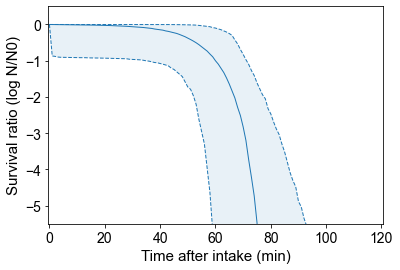

In [51]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0]*60, logSg0_quantile[:,0], logSg0_quantile[:,2], facecolor=Palette[0], alpha=0.1)
plt.plot(x[:,0]*60, logSg0_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0]*60, logSg0_quantile[:,0], lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0]*60, logSg0_quantile[:,1], lw=1, color=Palette[0], label="Survival ratio")

plt.ylabel("Survival ratio (log N/N0)", size=15, fontname="Arial")
plt.xlabel("Time after intake (min)",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-0.5, 120.5)
plt.ylim(-5.5, 0.5)
plt.show()


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

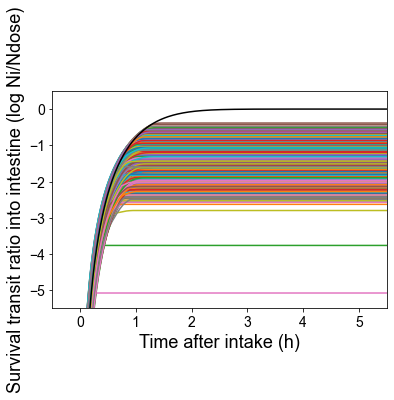

In [52]:
Ni_list = []

plt.rcParams["font.family"] = "Arial"

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Solid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Solid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Solid_retention["beta"][rcn_gastric_retention]
    
    for i in tqdm(range(len(x)),desc='Progress', leave=False):
        Sg = 10**logSg_using[i]
        
        dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Ni_t = Ni_t + dNi
        Ni[i, 0] = Ni_t
        
        dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
        Total_t = Total_t + dTotal
        Total[i, 0] = Total_t    

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [53]:
with open('Ni_Solid_elder.pkl', 'wb') as f:

    pickle.dump(Ni_list, f)

In [54]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

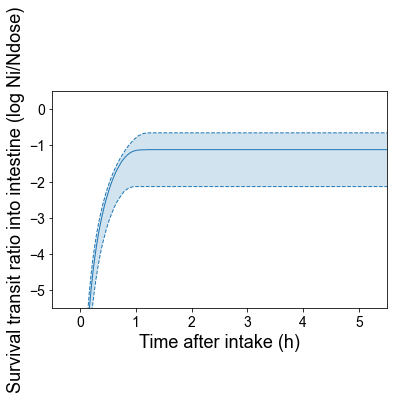

In [55]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Survival transit ratio into intestine (log Ni/Ndose)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


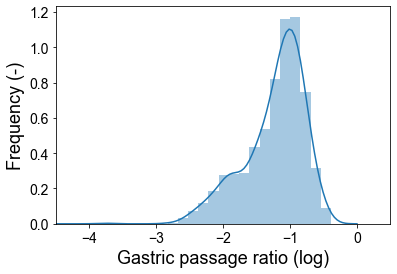

In [56]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [57]:
V = 319
Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.arange(-2, 6+1/10, 1/10, dtype="float")

S = 32*10**4

P_invasion_27_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_27_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_27_mean = np.zeros((len(logdose),1), dtype=float)

P_invasion_42_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_42_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_42_mean = np.zeros((len(logdose),1), dtype=float)

P_invasion_48_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_48_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_48_mean = np.zeros((len(logdose),1), dtype=float)

In [58]:
ratio_42_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
for n in tqdm(range(len(logdose)) ,desc='Progress', leave=False):
    warnings.simplefilter('ignore', RuntimeWarning)
    for k in tqdm(range(len(Ni_min[0, :])),desc='Progress', leave=False):

        rcn = random.randrange(len(samples_27["LogNmax"]))
        LogNmax_27 = samples_27["LogNmax"][rcn]
        Logmu_27 = samples_27["Logmu"][rcn]
        Nmax_27 = 10**LogNmax_27
        mu_27 = 10**Logmu_27

        LogNmax_42 = samples_42["LogNmax"][rcn]
        Logmu_42 = samples_42["Logmu"][rcn]
        Nmax_42 = 10**LogNmax_42
        mu_42 = 10**Logmu_42

        LogNmax_48 = samples_48["LogNmax"][rcn]
        Logmu_48 = samples_48["Logmu"][rcn]
        Nmax_48 = 10**LogNmax_48
        mu_48 = 10**Logmu_48

        for i in range(len(Ni_min[:, 0])):
        
            Ni = Ni_min[i, k]*10**logdose[n]
            
            T = i/60
            h = 1/60
    
            def ODE_27 (y, t):
                return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

            def ODE_42 (y, t):
                return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

            def ODE_48 (y, t):
                return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
            if i==0:
                Nc_min_27[i, k] = 0
                Nc_min_42[i, k] = 0
                Nc_min_48[i, k] = 0
                
            else:
                
                Nc_min_mean_27[i, k] = rk4 ( Nc_min_mean_27[i-1, k], T-h, h, ODE_27)[0]
                Nc_min_27[i, k] = Nc_min_mean_27[i, k]
        
                Nc_min_mean_42[i, k] = rk4 ( Nc_min_mean_42[i-1, k], T-h, h, ODE_42)[0]
                Nc_min_42[i, k] = Nc_min_mean_42[i, k]
        
                Nc_min_mean_48[i, k] = rk4 ( Nc_min_mean_48[i-1, k], T-h, h, ODE_48)[0]
                Nc_min_48[i, k] = Nc_min_mean_48[i, k]

        
        rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
        t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn],
                                        1/samples_Colonic_filling["beta"][rcn])))
        t = np.min((t,len(Ni_min[:, 0])-1))

        ratio_27 = Nc_min_27[t,k]/10**logdose[n]    
        ratio_27_mcmc[n,k] = ratio_27
        P_invasion_27 =  1- (1-ratio_27)**(10**logdose[n])
        P_invasion_27_mcmc[n,k] = P_invasion_27
        
        ratio_42 = Nc_min_42[t,k]/10**logdose[n] 
        ratio_42_mcmc[n,k] = ratio_42
        P_invasion_42 =  1- (1-ratio_42)**(10**logdose[n])
        P_invasion_42_mcmc[n,k] = P_invasion_42
        
        ratio_48 = Nc_min_48[t,k]/10**logdose[n]    
        P_invasion_48 =  1- (1-ratio_48)**(10**logdose[n])
        P_invasion_48_mcmc[n,k] = P_invasion_48
        
        
    P_invasion_27_quantile[n,:] =  np.quantile(P_invasion_27_mcmc[n,:][np.invert(np.isnan(P_invasion_27_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_27_mean[n,:] =  np.mean(P_invasion_27_mcmc[n,:][np.invert(np.isinf(P_invasion_27_mcmc[n,:])|np.isnan(P_invasion_27_mcmc[n,:]))])
    
    P_invasion_42_quantile[n,:] =  np.quantile(P_invasion_42_mcmc[n,:][np.invert(np.isnan(P_invasion_42_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_42_mean[n,:] =  np.mean(P_invasion_42_mcmc[n,:][np.invert(np.isinf(P_invasion_42_mcmc[n,:])|np.isnan(P_invasion_42_mcmc[n,:]))])
    
    P_invasion_48_quantile[n,:] =  np.quantile(P_invasion_48_mcmc[n,:][np.invert(np.isnan(P_invasion_48_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_48_mean[n,:] =  np.mean(P_invasion_48_mcmc[n,:][np.invert(np.isinf(P_invasion_48_mcmc[n,:])|np.isnan(P_invasion_48_mcmc[n,:]))])

Progress:   0%|          | 0/81 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

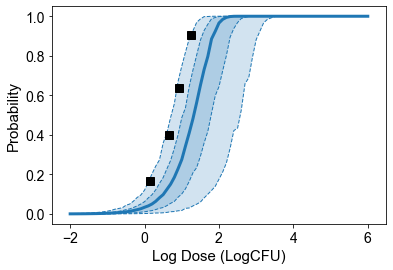

In [59]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_27_quantile[:,1], P_invasion_27_quantile[:,5], facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,1], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,5], lw=1, color=Palette[0],linestyle='--')


plt.fill_between(logdose, P_invasion_27_quantile[:,2], P_invasion_27_quantile[:,4], facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,4], lw=1, color=Palette[0],linestyle='--')


plt.plot(logdose, P_invasion_27_quantile[:,3], lw=3, color=Palette[0], label="RIMD 0366027")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [60]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_27_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.5581949416921387

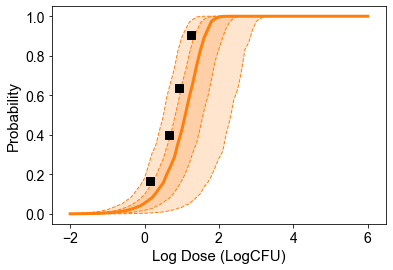

In [61]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_42_quantile[:,1], P_invasion_42_quantile[:,5], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,1], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,5], lw=1, color=Palette[1],linestyle='--')


plt.fill_between(logdose, P_invasion_42_quantile[:,2], P_invasion_42_quantile[:,4], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,2], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,4], lw=1, color=Palette[1],linestyle='--')


plt.plot(logdose, P_invasion_42_quantile[:,3], lw=3, color=Palette[1], label="RIMD 0366042")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [62]:
P_invasion_42_quantile[:,2]

array([1.83013267e-04, 2.28143563e-04, 2.93495566e-04, 3.69847809e-04,
       4.47116788e-04, 5.94753207e-04, 6.76190789e-04, 9.15623405e-04,
       1.18324889e-03, 1.55234390e-03, 1.90864320e-03, 2.34101832e-03,
       2.96211069e-03, 3.65147748e-03, 4.76581367e-03, 5.44179383e-03,
       7.16917438e-03, 8.82630938e-03, 1.13772624e-02, 1.48255893e-02,
       1.84079087e-02, 2.26343705e-02, 2.70473666e-02, 3.66283129e-02,
       4.59640620e-02, 5.71961607e-02, 7.21140242e-02, 8.48458684e-02,
       1.08049670e-01, 1.37204726e-01, 1.68181066e-01, 2.06188851e-01,
       2.54468387e-01, 3.10784114e-01, 3.58627641e-01, 4.38279080e-01,
       5.24456268e-01, 5.91755857e-01, 6.81543801e-01, 7.75390066e-01,
       8.35143183e-01, 8.92029077e-01, 9.42636497e-01, 9.73071387e-01,
       9.91671536e-01, 9.97265406e-01, 9.99305443e-01, 9.99872895e-01,
       9.99989630e-01, 9.99999629e-01, 9.99999996e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      

In [63]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_42_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.35826775808650374

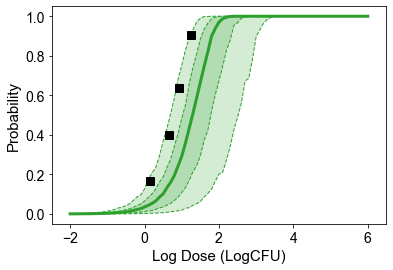

In [64]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_48_quantile[:,1], P_invasion_48_quantile[:,5], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,1], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,5], lw=1, color=Palette[2],linestyle='--')


plt.fill_between(logdose, P_invasion_48_quantile[:,2], P_invasion_48_quantile[:,4], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,2], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,4], lw=1, color=Palette[2],linestyle='--')


plt.plot(logdose, P_invasion_48_quantile[:,3], lw=3, color=Palette[2], label="RIMD 0366048")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [65]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_48_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.5581949416921387

In [66]:
P_invasion_mcmc = np.concatenate([P_invasion_27_mcmc, P_invasion_42_mcmc, P_invasion_48_mcmc], 1)
P_invasion_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_mean = np.zeros((len(logdose), 1), dtype=float)
for i in range(len(logdose)):
    P_invasion_quantile[i,:] =  np.quantile(P_invasion_mcmc[i,:][np.invert(np.isnan(P_invasion_mcmc[i,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_mean[i,0] =  np.mean(P_invasion_mcmc[i,:])

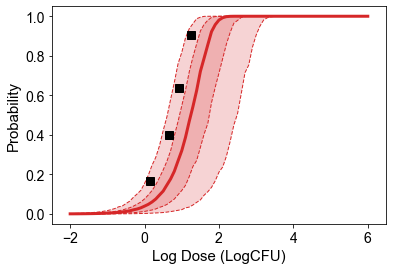

In [67]:
plt.figure()
plt.rcParams["font.family"] = "Arial"
Palette=sns.color_palette(n_colors=4)

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_quantile[:,1], P_invasion_quantile[:,5], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,1], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,5], lw=1, color=Palette[3],linestyle='--')


plt.fill_between(logdose, P_invasion_quantile[:,2], P_invasion_quantile[:,4], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,2], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,4], lw=1, color=Palette[3],linestyle='--')


plt.plot(logdose, P_invasion_quantile[:,3], lw=3, color=Palette[3], label="Total of isolations")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [68]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.5101220731620905

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

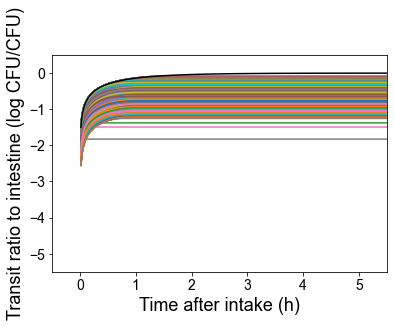

In [69]:
Ni_list = []

plt.rcParams["font.family"] = "Arial"
Palette=sns.color_palette(n_colors = rep_eat)

rcn_gastric_retention_list = np.zeros((rep_eat, 1), dtype=int)

for q in tqdm(range(rep_eat),desc='Progress', leave=False):
    
    Ni = np.zeros((len(x), 1), dtype=float)
    dNi = []
    Ni_t = 0

    Total = np.zeros((len(x), 1), dtype=float)
    dTotal = []
    Total_t = 0
    
    logSg_using = logSg0_list[:, q]
    
    rcn_gastric_retention = random.choice(range(len(samples_Liquid_retention["alpha"])))
    rcn_gastric_retention_list[q, 0] = rcn_gastric_retention
    alpha = samples_Liquid_retention["alpha"][rcn_gastric_retention]
    beta = samples_Liquid_retention["beta"][rcn_gastric_retention]
    
    for i in tqdm(range(len(x)),desc='Progress', leave=False):
        if i == 0:
            Ni[i, 0] = 0
        else:
            Sg = 10**logSg_using[i]
        
            dNi = Sg*gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Ni_t = Ni_t + dNi
            Ni[i, 0] = Ni_t
        
            dTotal = gamma.pdf(60*x[i], alpha, loc=0, scale=1./beta)
            Total_t = Total_t + dTotal
            Total[i, 0] = Total_t    

    plt.plot(x[:,0], np.log10(Ni[:,0]), marker="", color=Palette[q])

    
    if q == 0:
        Ni_list = Ni
    else:
        Ni_list = np.concatenate([Ni_list, Ni], axis = -1) 
    
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)

plt.plot(x[:,0], np.log10(Total[:,0]), marker="", color='black')

plt.ylabel("Transit ratio to intestine (log CFU/CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.show()

In [70]:
with open('Ni_Liquid_elder.pkl', 'wb') as f:

    pickle.dump(Ni_list, f)

In [71]:
Ni_quantile = np.zeros((len(Ni_list[:,0]), 3), dtype=float)

for n in tqdm(range(len(Ni_list[:,0])),desc='Progress', leave=False):
    Ni_quantile[n,:] =  np.quantile(Ni_list[n,:],[ 0.05, 0.5, 0.95])

Progress:   0%|          | 0/901 [00:00<?, ?it/s]

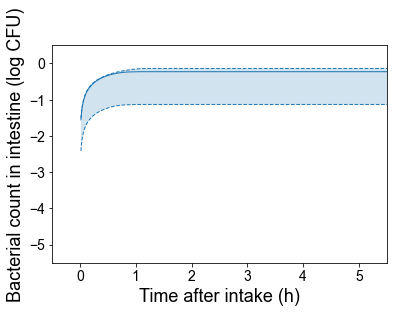

In [72]:
plt.rcParams["font.family"] = "Arial"

    
plt.fill_between(x[:,0], np.log10(Ni_quantile[:,0]), np.log10(Ni_quantile[:,2]), facecolor=Palette[0], alpha=0.2)
plt.plot(x[:,0], np.log10(Ni_quantile[:,2]), lw=1, color=Palette[0],linestyle='--')
plt.plot(x[:,0], np.log10(Ni_quantile[:,0]), lw=1, color=Palette[0],linestyle='--')


plt.plot(x[:,0], np.log10(Ni_quantile[:,1]), lw=1, color=Palette[0], label="Survival ratio")



plt.ylabel("Bacterial count in intestine (log CFU)", size=18, fontname="Arial")
plt.xlabel("Time after intake (h)", size=18, fontname="Arial")
plt.xlim(-0.5, 5.5)
plt.ylim(-5.5, 0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


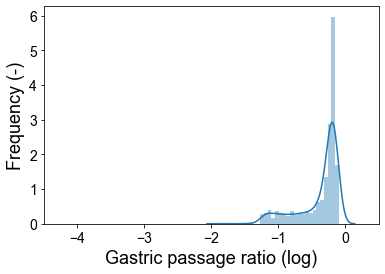

In [73]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
sns.distplot(np.log10(Ni_list)[-1,:])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric passage ratio (log)",size=18,fontname="Arial")
plt.xlim(-4.5, 0.5)
plt.show()

In [74]:
V = 319
Ni_min = Ni_list

Nc_min_mean_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_27 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_42 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

Nc_min_mean_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)
Nc_min_48 = np.zeros((len(Ni_min[:, 0]), len(Ni_min[0, :])), dtype=float)

logdose = np.arange(-2, 6+1/10, 1/10, dtype="float")

S = 32*10**4

P_invasion_27_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_27_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_27_mean = np.zeros((len(logdose),1), dtype=float)

P_invasion_42_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_42_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_42_mean = np.zeros((len(logdose),1), dtype=float)

P_invasion_48_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
P_invasion_48_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_48_mean = np.zeros((len(logdose),1), dtype=float)

In [75]:
ratio_42_mcmc = np.zeros((len(logdose), len(Ni_min[0,:])), dtype=float)
for n in tqdm(range(len(logdose)) ,desc='Progress', leave=False):
    warnings.simplefilter('ignore', RuntimeWarning)
    for k in tqdm(range(len(Ni_min[0, :])),desc='Progress', leave=False):

        rcn = random.randrange(len(samples_27["LogNmax"]))
        LogNmax_27 = samples_27["LogNmax"][rcn]
        Logmu_27 = samples_27["Logmu"][rcn]
        Nmax_27 = 10**LogNmax_27
        mu_27 = 10**Logmu_27

        LogNmax_42 = samples_42["LogNmax"][rcn]
        Logmu_42 = samples_42["Logmu"][rcn]
        Nmax_42 = 10**LogNmax_42
        mu_42 = 10**Logmu_42

        LogNmax_48 = samples_48["LogNmax"][rcn]
        Logmu_48 = samples_48["Logmu"][rcn]
        Nmax_48 = 10**LogNmax_48
        mu_48 = 10**Logmu_48

        for i in range(len(Ni_min[:, 0])):
        
            Ni = Ni_min[i, k]*10**logdose[n]
            
            T = i/60
            h = 1/60
    
            def ODE_27 (y, t):
                return mu_27*(Ni-y)*(S*Nmax_27 - y)/V

            def ODE_42 (y, t):
                return mu_42*(Ni-y)*(S*Nmax_42 - y)/V

            def ODE_48 (y, t):
                return mu_48*(Ni-y)*(S*Nmax_48 - y)/V
    
            if i==0:
                Nc_min_27[i, k] = 0
                Nc_min_42[i, k] = 0
                Nc_min_48[i, k] = 0
                
            else:
                
                Nc_min_mean_27[i, k] = rk4 ( Nc_min_mean_27[i-1, k], T-h, h, ODE_27)[0]
                Nc_min_27[i, k] = Nc_min_mean_27[i, k]
        
                Nc_min_mean_42[i, k] = rk4 ( Nc_min_mean_42[i-1, k], T-h, h, ODE_42)[0]
                Nc_min_42[i, k] = Nc_min_mean_42[i, k]
        
                Nc_min_mean_48[i, k] = rk4 ( Nc_min_mean_48[i-1, k], T-h, h, ODE_48)[0]
                Nc_min_48[i, k] = Nc_min_mean_48[i, k]

        
        rcn = random.choice(range(len(samples_Colonic_filling["alpha"])))
        t = int(round(np.random.gamma(samples_Colonic_filling["alpha"][rcn],
                                        1/samples_Colonic_filling["beta"][rcn])))
        t = np.min((t,len(Ni_min[:, 0])-1))

        ratio_27 = Nc_min_27[t,k]/10**logdose[n]    
        ratio_27_mcmc[n,k] = ratio_27
        P_invasion_27 =  1- (1-ratio_27)**(10**logdose[n])
        P_invasion_27_mcmc[n,k] = P_invasion_27
        
        ratio_42 = Nc_min_42[t,k]/10**logdose[n] 
        ratio_42_mcmc[n,k] = ratio_42
        P_invasion_42 =  1- (1-ratio_42)**(10**logdose[n])
        P_invasion_42_mcmc[n,k] = P_invasion_42
        
        ratio_48 = Nc_min_48[t,k]/10**logdose[n]    
        P_invasion_48 =  1- (1-ratio_48)**(10**logdose[n])
        P_invasion_48_mcmc[n,k] = P_invasion_48
        
        
    P_invasion_27_quantile[n,:] =  np.quantile(P_invasion_27_mcmc[n,:][np.invert(np.isnan(P_invasion_27_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_27_mean[n,:] =  np.mean(P_invasion_27_mcmc[n,:][np.invert(np.isinf(P_invasion_27_mcmc[n,:])|np.isnan(P_invasion_27_mcmc[n,:]))])
    
    P_invasion_42_quantile[n,:] =  np.quantile(P_invasion_42_mcmc[n,:][np.invert(np.isnan(P_invasion_42_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_42_mean[n,:] =  np.mean(P_invasion_42_mcmc[n,:][np.invert(np.isinf(P_invasion_42_mcmc[n,:])|np.isnan(P_invasion_42_mcmc[n,:]))])
    
    P_invasion_48_quantile[n,:] =  np.quantile(P_invasion_48_mcmc[n,:][np.invert(np.isnan(P_invasion_48_mcmc[n,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_48_mean[n,:] =  np.mean(P_invasion_48_mcmc[n,:][np.invert(np.isinf(P_invasion_48_mcmc[n,:])|np.isnan(P_invasion_48_mcmc[n,:]))])

Progress:   0%|          | 0/81 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

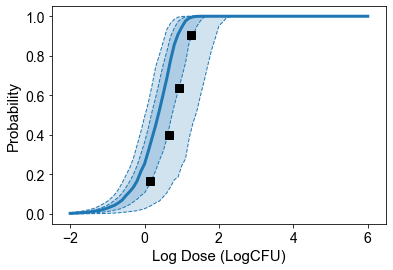

In [76]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_27_quantile[:,1], P_invasion_27_quantile[:,5], facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,1], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,5], lw=1, color=Palette[0],linestyle='--')


plt.fill_between(logdose, P_invasion_27_quantile[:,2], P_invasion_27_quantile[:,4], facecolor=Palette[0], alpha=0.2)
plt.plot(logdose, P_invasion_27_quantile[:,2], lw=1, color=Palette[0],linestyle='--')
plt.plot(logdose, P_invasion_27_quantile[:,4], lw=1, color=Palette[0],linestyle='--')


plt.plot(logdose, P_invasion_27_quantile[:,3], lw=3, color=Palette[0], label="RIMD 0366027")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [77]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_27_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.39459903765540055

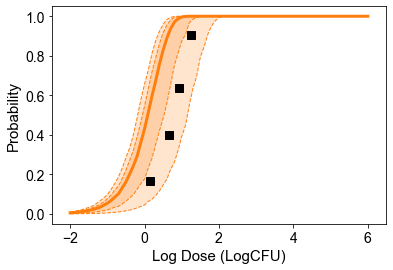

In [78]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_42_quantile[:,1], P_invasion_42_quantile[:,5], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,1], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,5], lw=1, color=Palette[1],linestyle='--')


plt.fill_between(logdose, P_invasion_42_quantile[:,2], P_invasion_42_quantile[:,4], facecolor=Palette[1], alpha=0.2)
plt.plot(logdose, P_invasion_42_quantile[:,2], lw=1, color=Palette[1],linestyle='--')
plt.plot(logdose, P_invasion_42_quantile[:,4], lw=1, color=Palette[1],linestyle='--')


plt.plot(logdose, P_invasion_42_quantile[:,3], lw=3, color=Palette[1], label="RIMD 0366042")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [79]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_42_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.6420488721682557

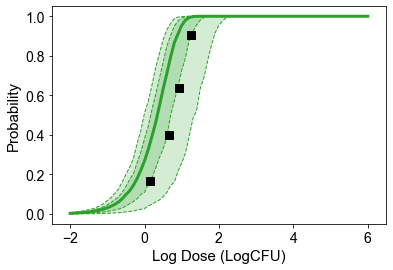

In [80]:
plt.figure()
plt.rcParams["font.family"] = "Arial"

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_48_quantile[:,1], P_invasion_48_quantile[:,5], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,1], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,5], lw=1, color=Palette[2],linestyle='--')


plt.fill_between(logdose, P_invasion_48_quantile[:,2], P_invasion_48_quantile[:,4], facecolor=Palette[2], alpha=0.2)
plt.plot(logdose, P_invasion_48_quantile[:,2], lw=1, color=Palette[2],linestyle='--')
plt.plot(logdose, P_invasion_48_quantile[:,4], lw=1, color=Palette[2],linestyle='--')


plt.plot(logdose, P_invasion_48_quantile[:,3], lw=3, color=Palette[2], label="RIMD 0366048")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [81]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_48_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.39459903765540055

In [82]:
P_invasion_mcmc = np.concatenate([P_invasion_27_mcmc, P_invasion_42_mcmc, P_invasion_48_mcmc], 1)
P_invasion_quantile = np.zeros((len(logdose), 7), dtype=float)
P_invasion_mean = np.zeros((len(logdose), 1), dtype=float)
for i in range(len(logdose)):
    P_invasion_quantile[i,:] =  np.quantile(P_invasion_mcmc[i,:][np.invert(np.isnan(P_invasion_mcmc[i,:]))],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    P_invasion_mean[i,0] =  np.mean(P_invasion_mcmc[i,:])

In [83]:
P_invasion_quantile

array([[2.21884548e-04, 3.28655071e-04, 1.45937039e-03, 3.49095804e-03,
        5.71191559e-03, 9.27106888e-03, 1.05219911e-02],
       [2.53368106e-04, 4.20847605e-04, 1.76070152e-03, 4.35174890e-03,
        7.21948342e-03, 1.16122802e-02, 1.38188309e-02],
       [3.51871906e-04, 5.44293538e-04, 2.25978846e-03, 5.55525167e-03,
        9.39413359e-03, 1.50883189e-02, 1.71816999e-02],
       [4.13964748e-04, 6.19471949e-04, 2.73554047e-03, 7.02176280e-03,
        1.15294469e-02, 1.78254932e-02, 2.19708183e-02],
       [4.94098161e-04, 8.34652642e-04, 3.59489762e-03, 8.77864211e-03,
        1.45645734e-02, 2.39422845e-02, 2.77049131e-02],
       [6.32328296e-04, 1.05896037e-03, 4.43400106e-03, 1.08964420e-02,
        1.81217089e-02, 2.94977723e-02, 3.38146979e-02],
       [8.45833300e-04, 1.27515305e-03, 5.62437366e-03, 1.40547553e-02,
        2.29101830e-02, 3.59001527e-02, 4.25725444e-02],
       [1.05350422e-03, 1.59453330e-03, 7.08790076e-03, 1.80008422e-02,
        2.91248259e-02, 4

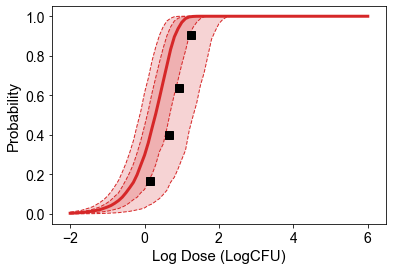

In [84]:
plt.figure()
plt.rcParams["font.family"] = "Arial"
Palette=sns.color_palette(n_colors=4)

pdf = PdfPages("Probability of C. jejuni invading.pdf")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Log Dose (LogCFU)",size=15,fontname="Arial")
plt.ylabel("Probability",size=15,fontname="Arial")
plt.xticks(np.arange(-4, 7, 2))
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,6.5])


plt.fill_between(logdose, P_invasion_quantile[:,1], P_invasion_quantile[:,5], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,1], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,5], lw=1, color=Palette[3],linestyle='--')


plt.fill_between(logdose, P_invasion_quantile[:,2], P_invasion_quantile[:,4], facecolor=Palette[3], alpha=0.2)
plt.plot(logdose, P_invasion_quantile[:,2], lw=1, color=Palette[3],linestyle='--')
plt.plot(logdose, P_invasion_quantile[:,4], lw=1, color=Palette[3],linestyle='--')


plt.plot(logdose, P_invasion_quantile[:,3], lw=3, color=Palette[3], label="Total of isolations")


data = pd.read_csv('../../Cell Invasion/Ill probability.csv') 
plt.plot(np.log10(data.Dose),data.Prob_ill,color="black", marker="s", linestyle="none", markersize=8)

plt.show()

In [85]:
idx = []
for i in range(len(data.Prob_ill)):
    idx.append(np.abs(np.asarray(P_invasion_quantile[:,3]) - data.Prob_ill[i]).argmin())
(np.sum(((logdose[idx]-np.log10(data.Dose))**2))/len(data.Dose))**0.5

0.4421001704352635